# P5-05: Results visualization - CRAG
- Used to display the prediction results
- Compares predicted masks with actual masks
- Compares the predicted objects with the actual objects 
- Illustration of Images, Masks and Glands

## Libraries, moduls

In [ ]:
# Imports
import numpy as np
from skimage.io import imread
import os
import matplotlib.pyplot as plt
import pickle # zum Speichern
import statistics # zur Auswertung
import scipy.stats as stat #+
# PL - Pinckaers, Litjens
from  MODULE.PL.metrics import ObjectDice, ObjectHausdorff, F1score
# JH - Jonas Heinke
from configuration_CRAG import Path   as PATH   # Paths and filenames
from configuration_CRAG import EXPERIMENT # Name / key of the experiment   
from MODULE.JH.img_array_transform import ArrayTransform as TRANSFORM
from MODULE.JH.visualize import Show as SHOW

In [ ]:
# For control
VERBOSE=True
# Experiment
print(EXPERIMENT)

CRAG(development_2021_10_27_praezision_14)_blocks6_cout2_optSGD_lr0.1_ep150_h768_w768_ft32


## 1. List of file paths

In [ ]:
path=PATH() # Instance of the class required for method call
# Source paths
path_experiment   = path.results  / EXPERIMENT   #  Results of the experiment
path_inputImages       = path.results  / EXPERIMENT/ 'images'
path_actualMasks  = path.results  / EXPERIMENT/ 'actualMasks'
path_predictMasks = path.results  / EXPERIMENT/ 'predictMasks'
path_predictMasksMorph = path.results  / EXPERIMENT/ 'predictMasksMorph'
path_predictObjects= path.results  / EXPERIMENT/ 'predictObjects' 
path_predictContourCodes= path.results  / EXPERIMENT/ 'predictContourCodes'
#  Paths with filenames
inputImages_filenames  = np.sort(path.get_filenames(path_inputImages  , dateifilter= '*.png'))
actualMasks_filenames  = np.sort(path.get_filenames(path_actualMasks, dateifilter= '*.png'))
predictMasks_filenames = np.sort(path.get_filenames(path_predictMasks, dateifilter= '*.png'))
predictMasksMorph_filenames   = np.sort(path.get_filenames(path_predictMasksMorph, dateifilter= '*.png'))
predictObjects_filenames      = np.sort(path.get_filenames(path_predictObjects, dateifilter= '*.png'))
predictContourCodes_filenames = np.sort(path.get_filenames(path_predictContourCodes , dateifilter= '*.pkl'))
# Number of samples
sample_anzahl=len(inputImages_filenames) # -> the same for everyone

In [ ]:
if VERBOSE:
    print(path_experiment)

/content/drive/.shortcut-targets-by-id/1i0GOg0AT_UuZJJUMz0D46PD2S2VfYbPB/NN_Segmentation/BA_Semantische_Segmentation/_Skript_Projekte/___P5_Eigenes_Projekt_Segmentation_CRAG/results/CRAG(development_2021_10_27_praezision_14)_blocks6_cout2_optSGD_lr0.1_ep150_h768_w768_ft32


In [ ]:
print(f'Number of image-mask-samples for prediction: {sample_anzahl}\n')
if VERBOSE:
    for idx in range(len(inputImages_filenames)):
        print(idx, ' | ', os.path.basename(inputImages_filenames[idx]),' >',\
                          os.path.basename(actualMasks_filenames[idx]) ,' >',\
                          os.path.basename(predictMasks_filenames[idx]) ,' >',\
                          os.path.basename(predictMasksMorph_filenames[idx]) ,' >',\
                          os.path.basename(predictContourCodes_filenames[idx]))

Number of image-mask-samples for prediction: 40

0  |  result_test_00.png  > result_test_00.png  > result_test_00.png  > result_test_00.png  > result_test_00.pkl
1  |  result_test_01.png  > result_test_01.png  > result_test_01.png  > result_test_01.png  > result_test_01.pkl
2  |  result_test_02.png  > result_test_02.png  > result_test_02.png  > result_test_02.png  > result_test_02.pkl
3  |  result_test_03.png  > result_test_03.png  > result_test_03.png  > result_test_03.png  > result_test_03.pkl
4  |  result_test_04.png  > result_test_04.png  > result_test_04.png  > result_test_04.png  > result_test_04.pkl
5  |  result_test_05.png  > result_test_05.png  > result_test_05.png  > result_test_05.png  > result_test_05.pkl
6  |  result_test_06.png  > result_test_06.png  > result_test_06.png  > result_test_06.png  > result_test_06.pkl
7  |  result_test_07.png  > result_test_07.png  > result_test_07.png  > result_test_07.png  > result_test_07.pkl
8  |  result_test_08.png  > result_test_08.png 

## 2. Read in images, masks and contours
- The size of the test images and test masks correspond to those of the training.

In [ ]:
input_images=[]
actual_masks=[]
predict_masks=[]
predict_masks_morph=[]
predict_objects=[]
contourcodes_list=[]
for idx in range(sample_anzahl):
    input_images.append(imread(inputImages_filenames[idx]))
    actual_masks.append(imread(actualMasks_filenames[idx]))
    predict_masks.append(imread(predictMasks_filenames[idx]))
    predict_masks_morph.append(imread(predictMasksMorph_filenames[idx]))
    predict_objects.append(imread(predictObjects_filenames[idx]))
    file=open(predictContourCodes_filenames[idx], 'rb')
    contourcodes_list.append(pickle.load(file))   
if VERBOSE:    
    print(input_images[0].shape, actual_masks[0].shape, predict_masks[0].shape, predict_masks_morph[0].shape, predict_objects[0].shape)

(768, 768, 3) (768, 768) (768, 768) (768, 768) (768, 768)


## 3. Evaluation of the test set (MEASURE)

### a) Evaluation of the prediction masks without post-processing

In [ ]:
if VERBOSE:
    print(actual_masks[0])
    print(predict_masks[0])

[[0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 [0 0 0 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[  0   0   0 ... 255   0   0]
 [  0   0   0 ... 255 255   0]
 [  0   0   0 ... 255 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
transform=TRANSFORM()
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
i_leer=0
anzahl=0
dice_list=[]
protokolldatei = open(path_experiment / 'protocol_prediction_class-based.txt','w')
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks.shape: {predict_masks[0].shape}\n\n')
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
  try:
    if actual_masks[idx].max() != 0 and predict_masks[idx].max != 0:
      actual_mask= transform.twoClasses(actual_masks[idx])
      predict_mask= predict_masks[idx]
      dice_img = ObjectDice(predict_mask,        actual_mask)
      dice_list.append(dice_img) 
      f1_img = F1score(predict_mask,              actual_mask)
      hausdorff_img = ObjectHausdorff(predict_mask,  actual_mask)
      dice += dice_img
      f1 += f1_img
      hausdorff += hausdorff_img
      print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:14.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictMasks_filenames[idx])}')
      print(print_string)
      anzahl += 1
      # --- Protokoll ---
      protokolldatei.write(print_string+'\n')
      #-------------------------------------
    else:
      i_leer += 1
      print('Leer: ',i_leer, 'Cycle', idx)   
  except:
    i_error += 1
    print('Error: ',i_error, 'Cycle', idx)

 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.886 |     1.000 |         34.015 | result_test_00.png | result_test_00.png
   1 |     0.909 |     1.000 |         89.006 | result_test_01.png | result_test_01.png
   2 |     0.790 |     1.000 |        570.040 | result_test_02.png | result_test_02.png
   3 |     0.827 |     1.000 |        193.259 | result_test_03.png | result_test_03.png
   4 |     0.799 |     1.000 |        115.004 | result_test_04.png | result_test_04.png
   5 |     0.960 |     1.000 |         21.095 | result_test_05.png | result_test_05.png
   6 |     0.811 |     1.000 |        115.109 | result_test_06.png | result_test_06.png
   7 |     0.961 |     1.000 |         43.863 | result_test_07.png | result_test_07.png
   8 |     0.933 |     1.000 |        112.432 | result_test_08.png | result_test_08.png
   9 |     0.851 |     1.000 |        275.530 | result_test_09.png | result_test_09.png
  10 |     0.962 |     1.000 |       

In [ ]:
title = '\n Prediction, class-based'
anzahl_emty_error = f'\n count io.: {anzahl} | empty: {i_leer} |  error: {i_error}'
kenngroessen = f'\n All result parameters (Average value of experiment) -> dice-idx: {dice / anzahl} | f1-score: {f1 / anzahl} | weighted shape: {hausdorff / anzahl}'
mittel_median = f'\n dice -> mittelwert: {np.mean(dice_list)} | Median: {statistics.median(dice_list)}'
standard_konvidenz = f'\n dice -> Standardabweichung S: {np.std(dice_list)} | Konfidenzintervalle mit t: {stat.t.interval(alpha=0.95, df=len(dice_list)-1, loc=np.mean(dice_list), scale=stat.sem(dice_list)) }' 
min_max_spannweite = f'\n dice -> Min: {min(dice_list)} | Max: {max(dice_list)} | Spannweite: {max(dice_list) - min(dice_list)}'
# Display
print(title)
print(anzahl_emty_error)
print(kenngroessen)
print(mittel_median ) 
print(standard_konvidenz)
print(min_max_spannweite)
# File
protokolldatei.write(title)
protokolldatei.write(anzahl_emty_error)
protokolldatei.write(kenngroessen)
protokolldatei.write(mittel_median)
protokolldatei.write(standard_konvidenz)
protokolldatei.write(min_max_spannweite)

protokolldatei.close() 


 Prediction, class-based

 count io.: 40 | empty: 0 |  error: 0

 All result parameters (Average value of experiment) -> dice-idx: 0.8933089649592908 | f1-score: 1.0 | weighted shape: 156.2120533196284

 dice -> mittelwert: 0.893308964959291 | Median: 0.9071317376831682

 dice -> Standardabweichung S: 0.05394368241154458 | Konfidenzintervalle mit t: (0.8758371585332011, 0.9107807713853809)

 dice -> Min: 0.7813528199606733 | Max: 0.9676956833438335 | Spannweite: 0.1863428633831602


### b) Evaluation of the post-processing prediction masks

In [ ]:
dice, hausdorff, f1, dice_full = 0, 0, 0, 0
i_error=0
i_leer
anzahl=0
dice_list=[]

protokolldatei = open(path_experiment /\
                      'protocol_prediction_with_post-processing_class-base.txt','w')
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'input_images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks_morph.shape: {predict_masks[0].shape}\n\n')
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
  try:
    if actual_masks[idx].max() != 0 and predict_masks_morph[idx].max != 0:
      # Compare objects with the masks of the same class
      actual_mask       = transform.twoClasses(actual_masks[idx])
      predict_mask_morph=predict_masks_morph[idx]
      dice_img = ObjectDice(predict_mask_morph,        actual_mask)
      dice_list.append(dice_img) 
      f1_img = F1score(predict_mask_morph,              actual_mask)
      hausdorff_img = ObjectHausdorff(predict_mask_morph,  actual_mask)
      dice += dice_img
      f1 += f1_img
      hausdorff += hausdorff_img
      print_string=(f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictMasksMorph_filenames[idx])}')
      print(print_string)
      anzahl +=1
      # --- Protokol ---
      protokolldatei.write(print_string+'\n')
      #-------------------------------------
    else:
      i_leer += 1
      print('Leer: ',i_leer, 'Cycle', idx)      
  except:
    i_error += 1
    print('Error: ',i_error, 'Cycle: ', idx)


 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.883 |     1.000 |       406.647 | result_test_00.png | result_test_00.png
   1 |     0.912 |     1.000 |        85.000 | result_test_01.png | result_test_01.png
   2 |     0.800 |     1.000 |       560.985 | result_test_02.png | result_test_02.png
   3 |     0.815 |     1.000 |       129.139 | result_test_03.png | result_test_03.png
   4 |     0.795 |     1.000 |       204.919 | result_test_04.png | result_test_04.png
   5 |     0.970 |     1.000 |        52.479 | result_test_05.png | result_test_05.png
   6 |     0.803 |     1.000 |       114.791 | result_test_06.png | result_test_06.png
   7 |     0.965 |     1.000 |        40.311 | result_test_07.png | result_test_07.png
   8 |     0.936 |     1.000 |       110.345 | result_test_08.png | result_test_08.png
   9 |     0.847 |     1.000 |       191.442 | result_test_09.png | result_test_09.png
  10 |     0.962 |     1.000 |        13.454 | 

In [ ]:
title = '\n Prediction with post-processing, class-based'
anzahl_emty_error = f'\n count io.: {anzahl} | empty: {i_leer} |  error: {i_error}'
kenngroessen = f'\n All result parameters (Average value of experiment) -> dice-idx: {dice / anzahl} | f1-score: {f1 / anzahl} | weighted shape: {hausdorff / anzahl}'
mittel_median = f'\n dice -> mittelwert: {np.mean(dice_list)} | Median: {statistics.median(dice_list)}'
standard_konvidenz = f'\n dice -> Standardabweichung S: {np.std(dice_list)} | Konfidenzintervalle mit t: {stat.t.interval(alpha=0.95, df=len(dice_list)-1, loc=np.mean(dice_list), scale=stat.sem(dice_list)) }' 
min_max_spannweite = f'\n dice -> Min: {min(dice_list)} | Max: {max(dice_list)} | Spannweite: {max(dice_list) - min(dice_list)}'
# Display
print(title)
print(anzahl_emty_error)
print(kenngroessen)
print(mittel_median ) 
print(standard_konvidenz)
print(min_max_spannweite)
# File
protokolldatei.write(title)
protokolldatei.write(anzahl_emty_error)
protokolldatei.write(kenngroessen)
protokolldatei.write(mittel_median)
protokolldatei.write(standard_konvidenz)
protokolldatei.write(min_max_spannweite)

protokolldatei.close() 


 Prediction with post-processing, class-based

 count io.: 40 | empty: 0 |  error: 0

 All result parameters (Average value of experiment) -> dice-idx: 0.8941141590769087 | f1-score: 1.0 | weighted shape: 125.61038128157404

 dice -> mittelwert: 0.8941141590769088 | Median: 0.9093418688845583

 dice -> Standardabweichung S: 0.05558172151172182 | Konfidenzintervalle mit t: (0.8761118085574751, 0.9121165095963426)

 dice -> Min: 0.7691704482638934 | Max: 0.9701593263108477 | Spannweite: 0.2009888780469543


### c) Evaluation of the predicted glands (objects)

In [ ]:
# Bewerung der nachbearbeiten Prognosemasken
dice, hausdorff, f1, dice_full = 0, 0, 0, 0

i_error = 0
i_leer = 0
anzahl = 0
dice_list=[]

protokolldatei = open(path_experiment /\
                      'protokoll_prediction_with_post-processing_object-based.txt','w') #+
protokolldatei.write('---------------------------------------------\n')  #+
protokolldatei.write(f'images_res.shape: {input_images[0].shape},\
                    actual_masks_res.shape: {actual_masks[0].shape},\
                    predict_masks.shape: {predict_objects[0].shape}\n\n')
# Table header
print_string=(f' idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks')
print(print_string)
protokolldatei.write(print_string+'\n')
for idx in range(sample_anzahl):
  try:
    if actual_masks[idx].max() != 0 and predict_objects[idx].max != 0: 
        # The objects (glands) of the mask end are compared.
        actual_mask = actual_masks[idx]
        predict_object = predict_objects[idx]
        dice_img = ObjectDice(predict_object,        actual_mask)
        dice_list.append(dice_img)                                      # new
        f1_img = F1score(predict_object,              actual_mask)
        hausdorff_img = ObjectHausdorff(predict_object,  actual_mask)
        dice += dice_img
        f1 += f1_img
        hausdorff += hausdorff_img
        print_string = (f' {idx:3d} | {dice_img:9.3f} | {f1_img:9.3f} | {hausdorff_img:13.3f} | {os.path.basename(actualMasks_filenames[idx])} | {os.path.basename(predictObjects_filenames[idx])}')
        print(print_string)
        anzahl +=1
        # --- Protokol ---
        protokolldatei.write(print_string+'\n')
    else:
      i_leer += 1
      print('Leer: ',i_leer, 'Cycle', idx)      
  except:
    i_error += 1
    print('Error: ',i_error, 'Cycle: ', idx)

 idx | dice-idx  | f1-score  | weighted shape | actual masks       | predict masks
   0 |     0.652 |     0.500 |       196.916 | result_test_00.png | result_test_00.png
   1 |     0.573 |     0.432 |       148.648 | result_test_01.png | result_test_01.png
   2 |     0.554 |     0.182 |       237.958 | result_test_02.png | result_test_02.png
   3 |     0.701 |     0.111 |       368.818 | result_test_03.png | result_test_03.png
   4 |     0.712 |     0.677 |       105.495 | result_test_04.png | result_test_04.png
   5 |     0.859 |     0.733 |        83.120 | result_test_05.png | result_test_05.png
   6 |     0.608 |     0.400 |       168.318 | result_test_06.png | result_test_06.png
   7 |     0.599 |     0.600 |       358.346 | result_test_07.png | result_test_07.png
   8 |     0.839 |     0.667 |        60.695 | result_test_08.png | result_test_08.png
   9 |     0.802 |     0.522 |        68.205 | result_test_09.png | result_test_09.png
  10 |     0.922 |     0.952 |        17.546 | 

In [ ]:
title = '\n Prediction with post-processing, object-based'
anzahl_emty_error = f'\n count io.: {anzahl} | empty: {i_leer} |  error: {i_error}'
kenngroessen = f'\n All result parameters (Average value of experiment) -> dice-idx: {dice / anzahl} | f1-score: {f1 / anzahl} | weighted shape: {hausdorff / anzahl}'
mittel_median = f'\n dice -> mittelwert: {np.mean(dice_list)} | Median: {statistics.median(dice_list)}'
standard_konvidenz = f'\n dice -> Standardabweichung S: {np.std(dice_list)} | Konfidenzintervalle mit t: {stat.t.interval(alpha=0.95, df=len(dice_list)-1, loc=np.mean(dice_list), scale=stat.sem(dice_list)) }' 
min_max_spannweite = f'\n dice -> Min: {min(dice_list)} | Max: {max(dice_list)} | Spannweite: {max(dice_list) - min(dice_list)}'
# Display
print(title)
print(anzahl_emty_error)
print(kenngroessen)
print(mittel_median ) 
print(standard_konvidenz)
print(min_max_spannweite)
# File
protokolldatei.write(title)
protokolldatei.write(anzahl_emty_error)
protokolldatei.write(kenngroessen)
protokolldatei.write(mittel_median)
protokolldatei.write(standard_konvidenz)
protokolldatei.write(min_max_spannweite)

protokolldatei.close() 


 Prediction with post-processing, object-based

 count io.: 40 | empty: 0 |  error: 0

 All result parameters (Average value of experiment) -> dice-idx: 0.7619237112421887 | f1-score: 0.5998224950563816 | weighted shape: 132.57873737491317

 dice -> mittelwert: 0.7619237112421888 | Median: 0.7936956782746751

 dice -> Standardabweichung S: 0.12329302181614803 | Konfidenzintervalle mit t: (0.7219903638220949, 0.8018570586622827)

 dice -> Min: 0.49489209568939135 | Max: 0.9515512792316658 | Spannweite: 0.45665918354227447


[0.6518318509159036, 0.5725953154567796, 0.5536152264151812, 0.7006192243897804, 0.711693162595062, 0.8587002854333017, 0.6082631514004718, 0.5989872605497157, 0.8393120076091414, 0.8017836131417876, 0.9224338038900068, 0.6664608205713347, 0.9365859286937896, 0.8591460743790378, 0.9442865537628539, 0.6567550193421768, 0.7847755156821632, 0.8598695736396096, 0.7866320145620807, 0.6948039081783024, 0.9515512792316658, 0.8374280353778782, 0.9376410188805954, 0.865144868080246, 0.8122712309440907, 0.6243252392263847, 0.49489209568939135, 0.8040519247261079, 0.8057276392835927, 0.8521373798036892, 0.925773785011178, 0.8641966889777652, 0.7630068127872134, 0.8007593419872696, 0.669117603737405, 0.8310790617407509, 0.6799197259745229, 0.5223096341429184, 0.7171768189088172, 0.7092879545675906]


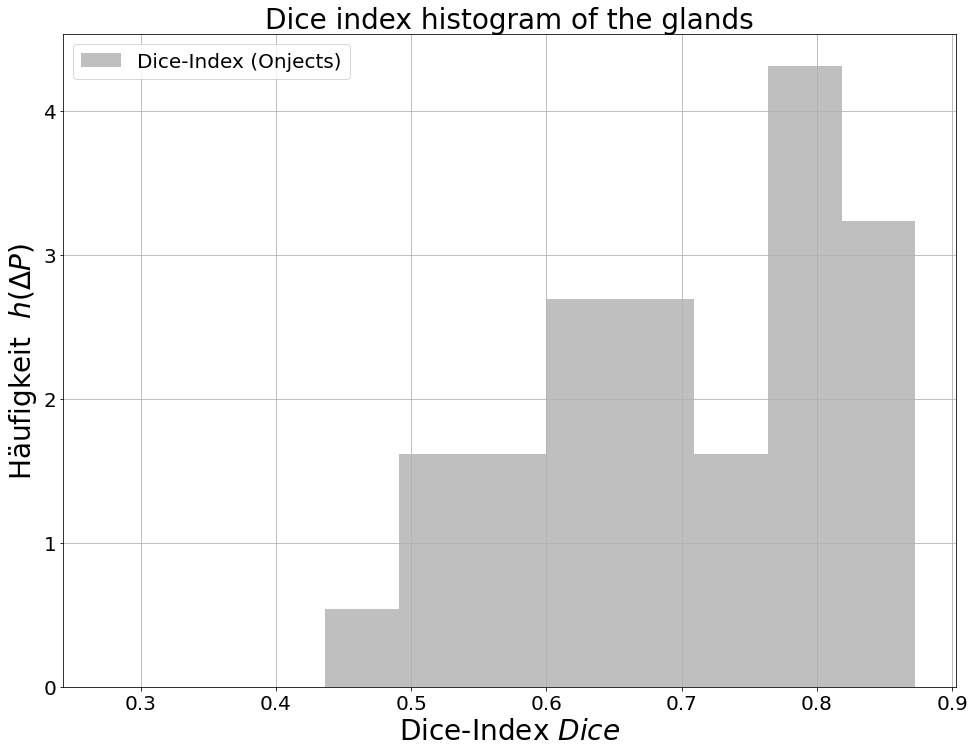

In [ ]:
# Histogram of Dice
print(dice_list)
fig=plt.figure(figsize=(16,12))
n,bins,patches=plt.hist(dice_list, bins=11, range=(0.3, 0.9),histtype='bar',\
                        align='left', color='gray',alpha=0.5, density=True, cumulative=False, label='Dice-Index (Onjects)')
plt.xlabel('Dice-Index $Dice$', size=28)
plt.ylabel('Häufigkeit  $h($$\Delta$$P)$', size=28)
plt.title("Dice index histogram of the glands", size=28)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.savefig(path_experiment /'Dice index histogram of the glands')
plt.show()

## 4. Draw the contour in an array and in an image

In [ ]:
class DrawCodeInArray():
    ''' 2. Zeichnet in ein Array, hier eine Kontur
    HINWEIS: Schnellere Berechnung wenn Klasse im Notebook'''
    #Konstruktor
    def __init__(self, verbose):
        super(DrawCodeInArray, self).__init__()
        # Steuert Ausgabe zur Kontrolle    
        self.verbose = verbose
    def all_contours(self, contour_array, contour_codes, element_value=255, depth=1):
        '''
        2.2 Verwendet den Code um eine Kontur in eine Array zu übertragen.
        Eingang Methode:
            contour_array - Array, dass verändert wird
            contour_codes - Koordinaten der Konturen (mehrere pro array)
            element_value - Wert, den die Konturpunkte erhalten
            depth - Dicke des Konturzuges (Konturdicke)
        Rückgabe:
            contour_array- Array mit Kontur entsprechend des Konturcods
        '''
        for contour in contour_codes:
            for point in contour:
                #print(point[0], point[1]) #x, y
                contour_array[int(point[0]), int(point[1])]=element_value
                try:
                    for d in range(0, depth): # Kontour dicker zeichnen
                        contour_array[int(point[0]+d), int(point[1])+d]=element_value
                        contour_array[int(point[0]-d), int(point[1])-d]=element_value
                except:
                    pass
        return contour_array

In [ ]:
# -> contourcodes_list[0][0][1][0])
# [listenelement], [contour eines Listenelementes], [Punkt]  , [Punktkoordinaten_x_y]
# Contour as an array
contourarray_list=[]
for idx in range(sample_anzahl):
    # It is drawn in here
    contour_array=np.zeros(predict_objects[idx].shape, dtype=int)
    drawInArray=DrawCodeInArray(True)
    # Contour of a mask
    conturcodes=contourcodes_list[idx]
    print(f'{idx}', end=', ')
    contourarray=drawInArray.all_contours(contour_array,conturcodes, 255, 2)
    contourarray_list.append(contourarray)  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

In [ ]:
# Draw the contour in the input image
contourimage_list=[]
for idx in range(sample_anzahl):
    contourimage=np.array(input_images[idx], copy=True)
    drawInArray=DrawCodeInArray(True)
    print(f'{idx}', end=', ')
    contourimage=drawInArray.all_contours(contourimage,contourcodes_list[idx], 0, 4)
    contourimage_list.append(contourimage) 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

### Comparison of visualization

In [ ]:
show=SHOW(experiment=EXPERIMENT, figsize=(15,30), fontsize=16)

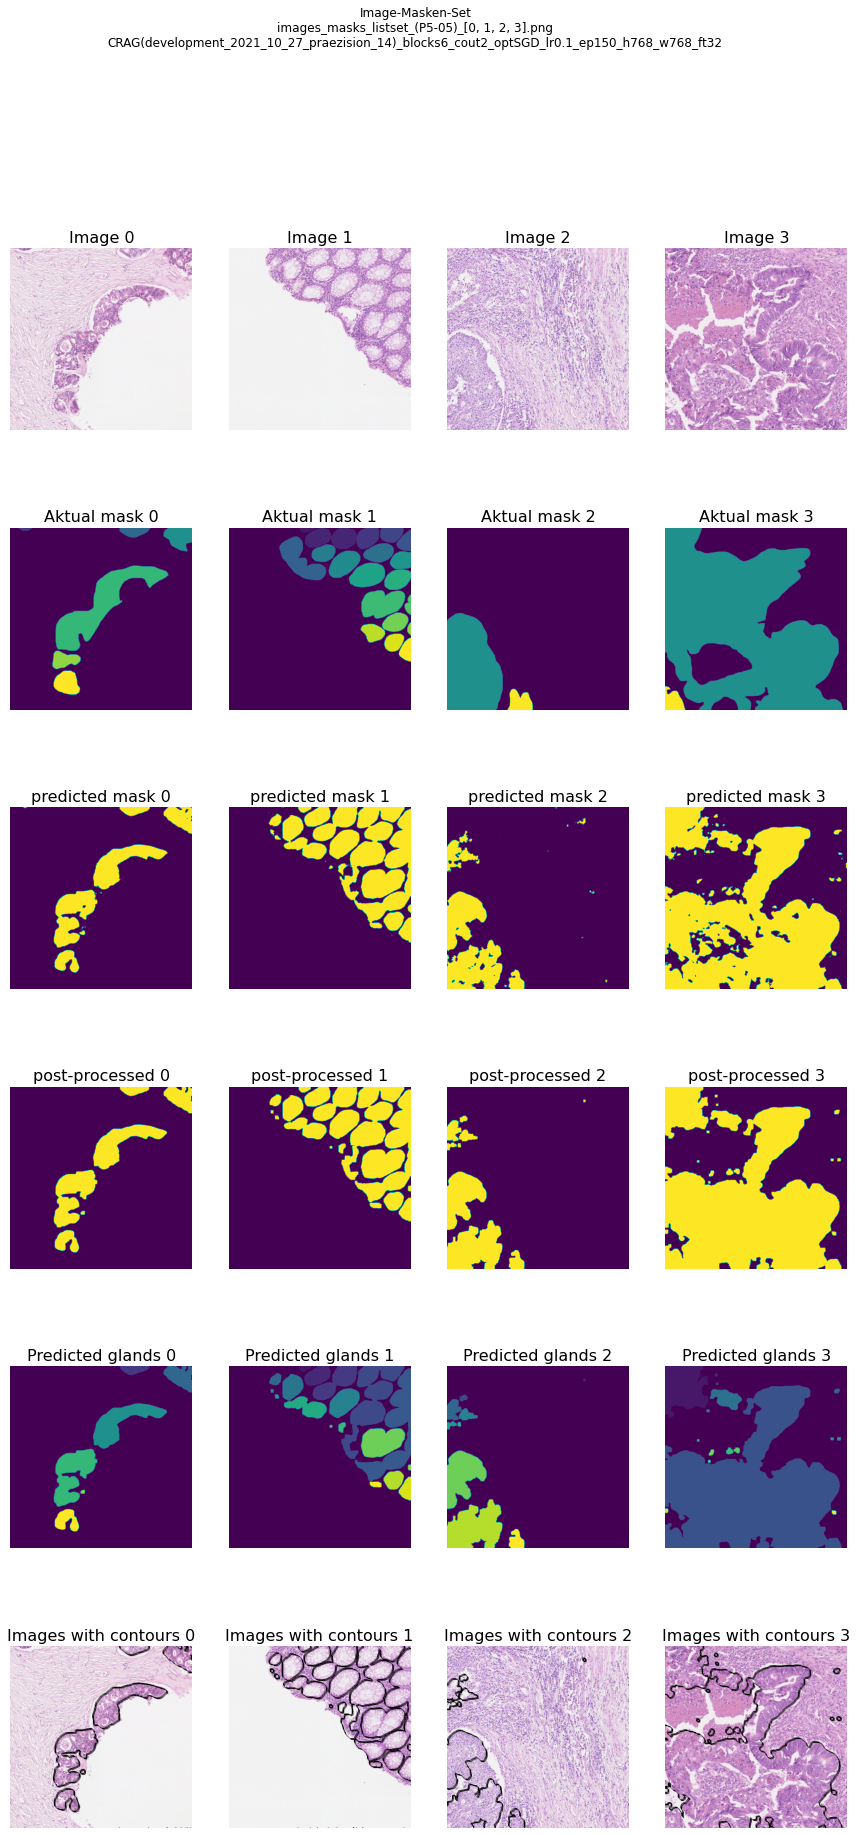

In [ ]:
idx_list=list([0,1,2, 3])
path_set= path_experiment  / f'images_masks_listset_(P5-05)_{str(idx_list)}.png'
listset=list([input_images, actual_masks,         predict_masks,\
              predict_masks_morph,     predict_objects,  contourimage_list ] )
titles=list(['Image', 'Actual mask', 'predicted mask',\
             'post-processed',    'Predicted glands', 'Images with contours'])
show.list_set(idx_list, listset,titles, path=path_set)

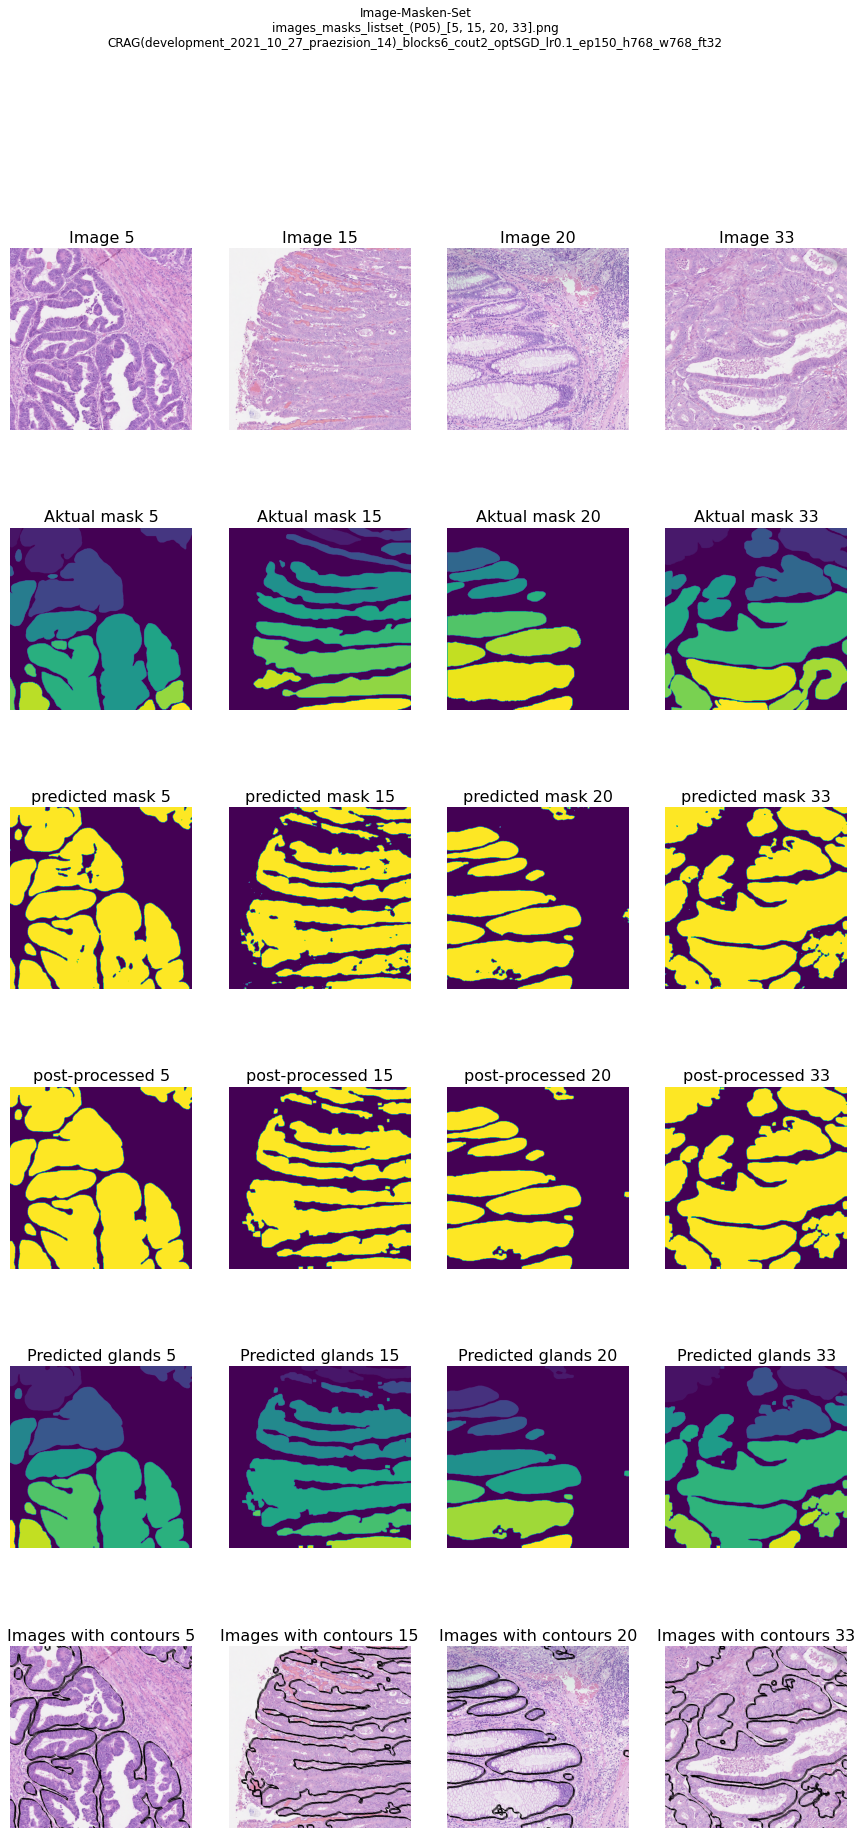

In [ ]:
idx_list=list([5,15,20,33])
path_set= path_experiment  / f'images_masks_listset_(P05)_{str(idx_list)}.png'
listset=list([input_images, actual_masks,         predict_masks,\
              predict_masks_morph,     predict_objects,  contourimage_list ] )
titles=list(['Image', 'Actual mask', 'predicted mask',\
             'post-processed',    'Predicted glands', 'Images with contours'])
show.list_set(idx_list, listset,titles, path=path_set)

In [ ]:
print('End of visualizing')

End of visualizing
